##### PyMC3 Examples

# Robust Regression with Outlier Detection

@author: Jonathan Sedar  
@email: jon@sedar.co  
@date: Mon 21 Dec 2015  

**A minimal reproducable example of Robust Regression with Outlier Detection using Hogg 2010 Signal vs Noise method.**

+ This is a complementary approach to the Student-T robust regression as illustrated in Thomas Wiecki's notebook in the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/GLM-robust/), that approach is also compared here.
+ This model returns a robust estimate of linear coefficients and an indication of which datapoints (if any) are outliers.
+ The likelihood evaluation is essentially a copy of eqn 17 in "Data analysis recipes: Fitting a model to data" - [Hogg 2010](http://arxiv.org/abs/1008.4686).
+ The model is adapted specifically from Jake Vanderplas' [implementation](http://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html) (3rd model tested).
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.


**Note:**

+ Python 3.4 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.
+ During development I've found that 3 data points are always indicated as outliers, but the remaining ordering of datapoints by decreasing outlier-hood is slightly unstable between runs: the posterior surface appears to have a small number of solutions with similar probability. 
+ Finally, if runs become unstable or Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.4
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano as thno
import theano.tensor as T 

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

## Load and Prepare Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

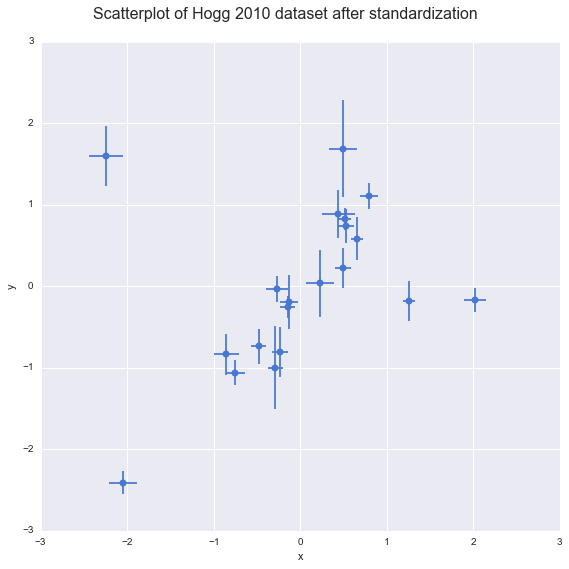

In [3]:
## cut & pasted directly from the fetch_hogg2010test() function
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

## scatterplot the standardized data
g = sns.FacetGrid(dfhoggs, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim((-3,3))
_ = g.axes[0][0].set_xlim((-3,3))

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)

**Observe**:  

+ Even judging just by eye, you can see these datapoints mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line

---

---

# Create Conventional OLS Model

The *linear model* is really simple and conventional:

$$\bf{y} = \beta^{T} \bf{X} + \bf{\sigma}$$

where:  

$\beta$ = coefs = $\{1, \beta_{j \in X_{j}}\}$  
$\sigma$ = the measured error in $y$ in the dataset `sigma_y`

##### Define model

**NOTE:**
+ We're using a simple linear OLS model with Normally distributed priors so that it behaves like a ridge regression

In [4]:
with pm.Model() as mdl_ols:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']
    
    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=thno.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y**2, observed=dfhoggs['y'])


##### Sample

In [5]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 4555.263214
         Iterations: 3
         Function evaluations: 110
 [-----------------100%-----------------] 2000 of 2000 complete in 0.6 sec

##### View Traces

**NOTE**: I'll 'burn' the traces to only retain the final 1000 samples

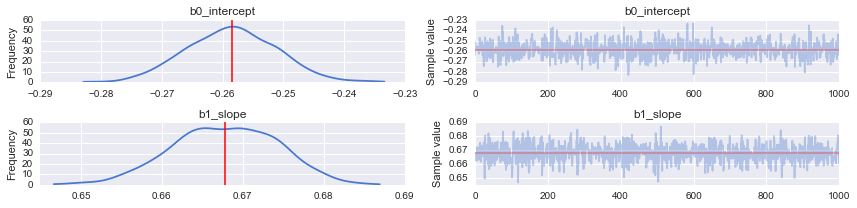

In [6]:
_ = pm.traceplot(traces_ols[-1000:], figsize=(12,len(traces_ols.varnames)*1.5),
                lines={k: v['mean'] for k, v in pm.df_summary(traces_ols[-1000:]).iterrows()})

**NOTE:** We'll illustrate this OLS fit and compare to the datapoints in the final plot

---

---

# Create Robust Model: Student-T Method

I've added this brief section in order to directly compare the Student-T based method exampled in Thomas Wiecki's notebook in the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/GLM-robust/)

Instead of using a Normal distribution for the likelihood, we use a Student-T, which has fatter tails. In theory this allows outliers to have a smaller mean square error in the likelihood, and thus have less influence on the regression estimation. This method does not produce inlier / outlier flags but is simpler and faster to run than the Signal Vs Noise model below, so a comparison seems worthwhile.

**Note:** we'll constrain the Student-T 'degrees of freedom' parameter `nu` to be an integer, but otherwise leave it as just another stochastic to be inferred: no need for prior knowledge.

##### Define Model

In [7]:
with pm.Model() as mdl_studentt:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']
    
    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=thno.config.floatX), name='sigma_y')
    
    ## define prior for Student T degrees of freedom
    nu = pm.DiscreteUniform('nu', lower=1, upper=100)

    ## Define Student T likelihood
    likelihood = pm.StudentT('likelihood', mu=yest, sd=sigma_y**2, nu=nu
                           ,observed=dfhoggs['y'])


##### Sample

In [8]:
with mdl_studentt:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## two-step sampling to allow Metropolis for nu (which is discrete)
    step1 = pm.NUTS([b0, b1])
    step2 = pm.Metropolis([nu])
    
    ## take samples
    traces_studentt = pm.sample(2000, start=start_MAP, step=[step1, step2], progressbar=True)

Optimization terminated successfully.
         Current function value: 430.443483
         Iterations: 3
         Function evaluations: 86
 [-----------------100%-----------------] 2000 of 2000 complete in 1.3 sec

##### View Traces

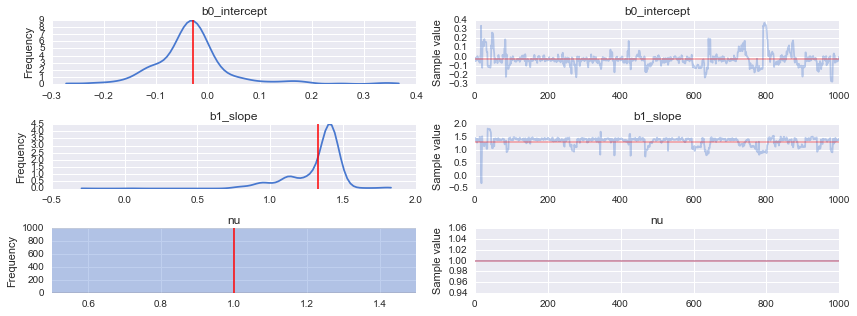

In [9]:
_ = pm.traceplot(traces_studentt[-1000:]
            ,figsize=(12,len(traces_studentt.varnames)*1.5)
            ,lines={k: v['mean'] for k, v in pm.df_summary(traces_studentt[-1000:]).iterrows()})

**Observe:**

+ Both parameters `b0` and `b1` show quite a skew to the right, possibly this is the action of a few samples regressing closer to the OLS estimate which is towards the left
+ The `nu` parameter seems very happy to stick at `nu = 1`, indicating that a fat-tailed Student-T likelihood has a better fit than a thin-tailed (Normal-like) Student-T likelihood.
+ The inference sampling also ran very quickly, almost as quickly as the conventional OLS


**NOTE:** We'll illustrate this Student-T fit and compare to the datapoints in the final plot

---

---

# Create Robust Model with Outliers: Hogg Method

Please read the paper (Hogg 2010) and Jake Vanderplas' code for more complete information about the modelling technique.

The general idea is to create a 'mixture' model whereby datapoints can be described by either the linear model (inliers) or a modified linear model with different mean and larger variance (outliers).


The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernouilli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
$\bf{B}$ is Bernoulli-distibuted $B_{i} \in [0_{(inlier)},1_{(outlier)}]$



##### Define model

In [10]:
def logp_signoise(yobs, is_outlier, yest_in, sigma_y_in, yest_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers. 
    NOTE: in this particular case we don't need to use theano's @as_op 
    decorator because (as stated by Twiecki in conversation) that's only 
    required if the likelihood cannot be expressed as a theano expression.
    We also now get the gradient computation for free.
    '''   
    
    # likelihood for inliers
    pdfs_in = T.exp(-(yobs - yest_in + 1e-6)**2 / (2 * sigma_y_in**2)) 
    pdfs_in /= T.sqrt(2 * np.pi * sigma_y_in**2)
    logL_in = T.sum(T.log(pdfs_in) * (1 - is_outlier))

    # likelihood for outliers
    pdfs_out = T.exp(-(yobs - yest_out + 1e-6)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2))) 
    pdfs_out /= T.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
    logL_out = T.sum(T.log(pdfs_out) * is_outlier)

    return logL_in + logL_out


In [22]:
with pm.Model() as mdl_signoise:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest_in = b0 + b1 * dfhoggs['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=100)
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100)

    ## Define Bernoulli inlier / outlier flags according to a hyperprior 
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0])  
       
    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = thno.shared(np.asarray(dfhoggs['y'], dtype=thno.config.floatX), name='yobs')
    sigma_y_in = thno.shared(np.asarray(dfhoggs['sigma_y']
                                , dtype=thno.config.floatX), name='sigma_y_in')
        
    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise,
                        observed={'yobs':yobs, 'is_outlier':is_outlier,
                                  'yest_in':yest_in, 'sigma_y_in':sigma_y_in,
                                  'yest_out':yest_out, 'sigma_y_out':sigma_y_out})


##### Sample

In [23]:
with mdl_signoise:

    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.NUTS([frac_outliers, yest_out, sigma_y_out, b0, b1])
    step2 = pm.BinaryMetropolis([is_outlier])

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_signoise = pm.sample(2000, start=start_MAP, step=[step1,step2], progressbar=True)

Optimization terminated successfully.
         Current function value: 155.449990
         Iterations: 3
         Function evaluations: 202
 [-----------------100%-----------------] 2000 of 2000 complete in 180.3 sec

##### View Traces

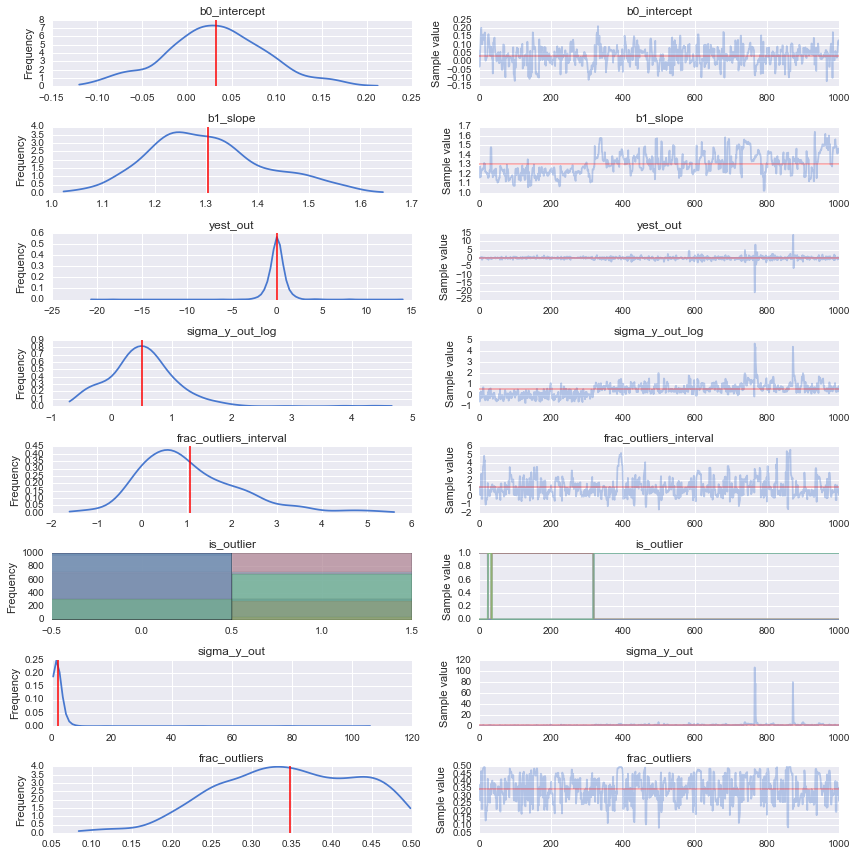

In [26]:
_ = pm.traceplot(traces_signoise[-1000:], figsize=(12,len(traces_signoise.varnames)*1.5),
            lines={k: v['mean'] for k, v in pm.df_summary(traces_signoise[-1000:]).iterrows()})

**NOTE:**:

+ During development I've found that 3 datapoints id=[1,2,3] are always indicated as outliers, but the remaining ordering of datapoints by decreasing outlier-hood is unstable between runs: the posterior surface appears to have a small number of solutions with very similar probability.
+ The NUTS sampler seems to work okay, and indeed it's a nice opportunity to demonstrate a custom likelihood which is possible to express as a theano function (thus allowing a gradient-based sampler like NUTS). However, with a more complicated dataset, I would spend time understanding this instability and potentially prefer using more samples under Metropolis-Hastings.

---

---

# Declare Outliers and Compare Plots

##### View ranges for inliers / outlier predictions

At each step of the traces, each datapoint may be either an inlier or outlier. We hope that the datapoints spend an unequal time being one state or the other, so let's take a look at the simple count of states for each of the 20 datapoints.

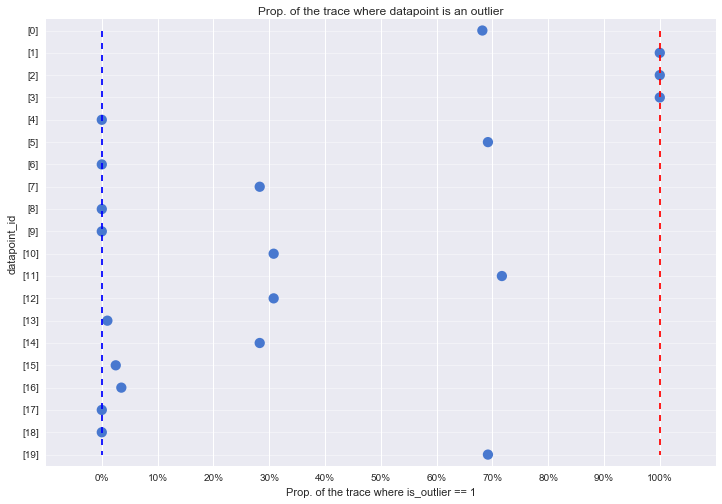

In [27]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in dfhoggs.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')

**Observe**:

+ The plot above shows the number of samples in the traces in which each datapoint is marked as an outlier, expressed as a percentage.
+ In particular, 3 points [1, 2, 3] spend >=95% of their time as outliers
+ Contrastingly, points at the other end of the plot close to 0% are our strongest inliers.
+ For comparison, the mean posterior value of `frac_outliers` is ~0.35, corresponding to roughly 7 of the 20 datapoints. You can see these 7 datapoints in the plot above, all those with a value >50% or thereabouts.
+ However, only 3 of these points are outliers >=95% of the time. 
+ See note above regarding instability between runs.

The 95% cutoff we choose is subjective and arbitrary, but I prefer it for now, so let's declare these 3 to be outliers and see how it looks compared to Jake Vanderplas' outliers, which were declared in a slightly different way as points with means above 0.68.

##### Declare outliers

**Note:**
+ I will declare outliers to be datapoints that have value == 1 at the 5-percentile cutoff, i.e. in the percentiles from 5 up to 100, their values are 1. 
+ Try for yourself altering cutoff to larger values, which leads to an objective ranking of outlier-hood.

In [28]:
cutoff = 5
dfhoggs['outlier'] = np.percentile(traces_signoise[-1000:]['is_outlier'],cutoff, axis=0)
dfhoggs['outlier'].value_counts()

0    17
1     3
Name: outlier, dtype: int64

## Posterior Prediction Plots for OLS vs StudentT vs SignalNoise

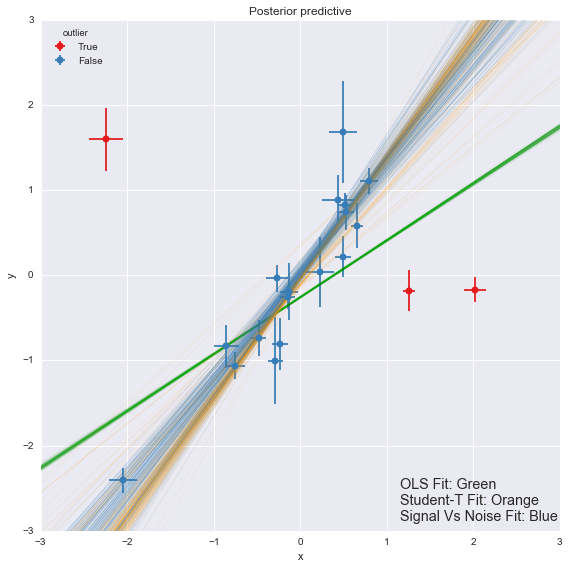

In [35]:
g = sns.FacetGrid(dfhoggs, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0_intercept'] + samp['b1_slope'] * x

pm.glm.plot_posterior_predictive(traces_ols[-1000:],
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='#00AA00', alpha=.1)

pm.glm.plot_posterior_predictive(traces_studentt[-1000:], lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#FF9900', alpha=.3)

pm.glm.plot_posterior_predictive(traces_signoise[-1000:], lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200,
        color=sns.palettes.color_palette('Set1')[1], alpha=.3)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='').add_legend()

_ = g.axes[0][0].annotate('OLS Fit: Green\nStudent-T Fit: Orange\nSignal Vs Noise Fit: Blue',
                          size='x-large', xy=(1,0), xycoords='axes fraction',
                          xytext=(-160,10), textcoords='offset points')
_ = g.axes[0][0].set_ylim((-3,3))

**Observe**:

+ The posterior preditive fit for:
    + the **OLS model** is shown in **Green** and as expected, it doesn't appear to fit the majority of our datapoints very well, skewed by outliers
    + the **Robust Student-T model** is shown in **Orange** and does appear to fit the 'main axis' of datapoints quite well, ignoring outliers
    + the **Robust Signal vs Noise model** is shown in **Blue** and also appears to fit the 'main axis' of datapoints rather well, ignoring outliers.
    
    
+ We see that the **Robust Signal vs Noise model** also yields specific estimates of _which_ datapoints are outliers:
    + 17 'inlier' datapoints, in **Blue** and
    + 3 'outlier' datapoints shown in **Red**.
    + From a simple visual inspection, the classification seems fair, and agrees with Jake Vanderplas' findings.
    
    
+ Overall, it seems that:
    + the **Signal vs Noise model** behaves as promised, yielding a robust regression estimate and explicit labelling of inliers / outliers, but
    + the **Signal vs Noise model** is quite complex and whilst the regression seems robust and stable, the actual inlier / outlier labelling seems slightly unstable
    + if you simply want a robust regression without inlier / outlier labelling, the **Student-T model** may be a good compromise, offering a simple model, quick sampling, and a very similar estimate.

---